In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative/dataset.jsonl


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq

2025-05-01 09:39:11.193251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746092351.663942      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746092351.798717      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset = load_dataset("json", data_files="/kaggle/input/generative/dataset.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
def convert_to_qa(example):
    # Use instruction as input_text and cot_answer as target_text
    return {
        "input_text": example["instruction"],
        "target_text": example["cot_answer"]
    }

# Apply conversion
qa_dataset = dataset.map(convert_to_qa)

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

In [6]:
def preprocess(example):
    inputs = tokenizer(
        example["input_text"], max_length=512, padding="max_length", truncation=True
    )
    targets = tokenizer(
        example["target_text"], max_length=64, padding="max_length", truncation=True
    )
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_dataset = qa_dataset.map(preprocess, batched=True, remove_columns=["input_text", "target_text"])

Map:   0%|          | 0/56 [00:00<?, ? examples/s]

In [7]:
from datasets import DatasetDict

# Split original dataset (e.g., 90% train, 10% validation)
split_dataset = tokenized_dataset["train"].train_test_split(test_size=0.1, seed=42)

# Convert to DatasetDict format
tokenized_dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["test"]
})

In [8]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

In [9]:
from transformers import Trainer, TrainingArguments, TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to capture loss at each step
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])

    def get_losses(self):
        return self.losses

# Trainer
loss_logger = LossLoggerCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    callbacks=[loss_logger]
)

# Start training
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,2.648700
100,1.740900
150,1.395600
200,1.133300
250,1.138000
300,1.029800
350,0.847900
400,0.754500
450,0.818200
500,0.728800


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=700, training_loss=1.0586288670131139, metrics={'train_runtime': 595.6357, 'train_samples_per_second': 8.394, 'train_steps_per_second': 1.175, 'total_flos': 3423786762240000.0, 'train_loss': 1.0586288670131139, 'epoch': 100.0})

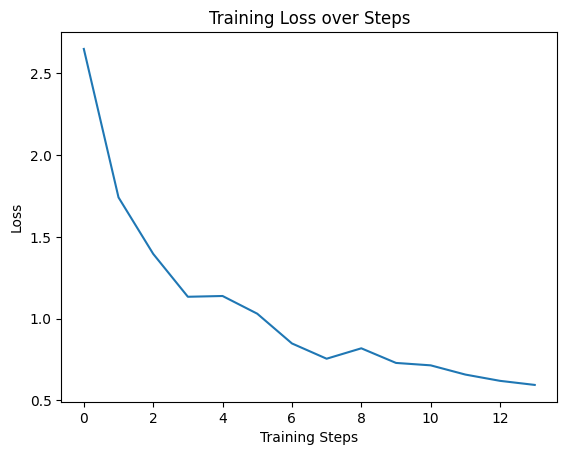

In [10]:
# After training, you can plot the loss graph
losses = loss_logger.get_losses()

# Plotting the loss
plt.plot(losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.show()

In [11]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/spiece.model',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [12]:
from transformers import pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./trained_model")
tokenizer = AutoTokenizer.from_pretrained("./trained_model")

qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Example input
input_text = "Generate a chain-of-thought answer: When was the University of California, Berkeley established?"

# Generate the output
output = qa_pipeline(input_text, max_length=256, do_sample=False)

# Print the generated text
print(output[0]["generated_text"])

Device set to use cuda:0


The University of California, Berkeley was established in 1892. The answer: 1892.


In [14]:
pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu

In [16]:
pip install rouge-score bert-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.0 MB/s eta 0:00:000:00:0100:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e0cf7e699a85744749759bb7851a453af6787606bc7141837d649b7ca8faea2b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1

In [17]:
import evaluate
from tqdm import tqdm

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [20]:
import evaluate
from tqdm import tqdm
from transformers import pipeline

# Load evaluation metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Reload the trained pipeline
qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Collect predictions and references
predictions, references = [], []

print("Generating predictions on validation set...")
for example in tqdm(tokenized_dataset["validation"]):
    input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    reference_text = tokenizer.decode(example["labels"], skip_special_tokens=True)
    
    output = qa_pipeline(input_text, max_length=64, clean_up_tokenization_spaces=True)[0]['generated_text']
    
    predictions.append(output.strip())
    references.append(reference_text.strip())

# Compute metrics
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)

# Display metrics
print("\n===== Evaluation Metrics =====")
print(f"BLEU Score     : {bleu_result['bleu']:.4f}")
print(f"  - Precisions : {[f'{p:.4f}' for p in bleu_result['precisions']]}")
print(f"ROUGE-1        : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2        : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L        : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum     : {rouge_result['rougeLsum']:.4f}")
print(f"METEOR         : {meteor_result['meteor']:.4f}")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Device set to use cuda:0


Generating predictions on validation set...


100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


===== Evaluation Metrics =====
BLEU Score     : 0.2871
  - Precisions : ['0.4924', '0.3240', '0.2349', '0.1812']
ROUGE-1        : 0.5252
ROUGE-2        : 0.3345
ROUGE-L        : 0.4421
ROUGE-Lsum     : 0.4412
METEOR         : 0.3993


In [21]:
# Re-import (if needed)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load t5-base model and tokenizer
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [22]:
# STEP 6: Training setup
from transformers import Seq2SeqTrainingArguments, Trainer, DataCollatorForSeq2Seq, TrainerCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="./results_t5_base",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

In [23]:
# STEP 7: Custom loss logger
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])

    def get_losses(self):
        return self.losses

loss_logger = LossLoggerCallback()

In [24]:
# STEP 8: Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    callbacks=[loss_logger]
)

# STEP 9: Training
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,2.628500
100,1.589000
150,1.118200
200,0.837500
250,0.728400
300,0.622500
350,0.554600
400,0.490600
450,0.459300
500,0.428400


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=700, training_loss=0.784006838117327, metrics={'train_runtime': 541.9299, 'train_samples_per_second': 9.226, 'train_steps_per_second': 1.292, 'total_flos': 3044789452800000.0, 'train_loss': 0.784006838117327, 'epoch': 100.0})

In [25]:
# STEP 10: Save model
model.save_pretrained("./trained_t5_base")
tokenizer.save_pretrained("./trained_t5_base")

('./trained_t5_base/tokenizer_config.json',
 './trained_t5_base/special_tokens_map.json',
 './trained_t5_base/spiece.model',
 './trained_t5_base/added_tokens.json',
 './trained_t5_base/tokenizer.json')

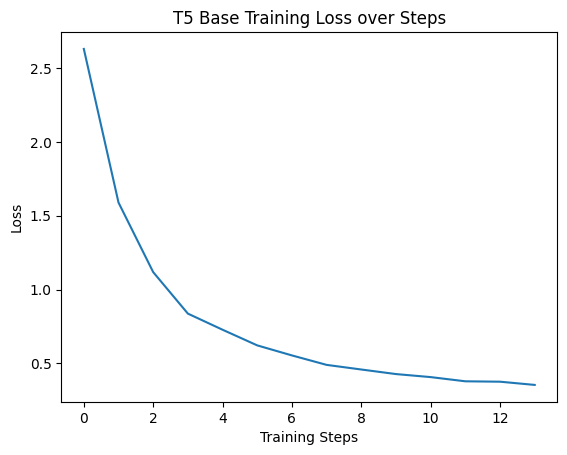

In [26]:
# STEP 11: Plot training loss
import matplotlib.pyplot as plt

losses = loss_logger.get_losses()
plt.plot(losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('T5 Base Training Loss over Steps')
plt.show()

In [27]:
# STEP 12: Evaluation Setup
from transformers import pipeline
import evaluate
from tqdm import tqdm

# Load trained model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./trained_t5_base")
tokenizer = AutoTokenizer.from_pretrained("./trained_t5_base")
qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Prepare predictions and references
predictions, references = [], []

print("Generating predictions on validation set...")
for example in tqdm(tokenized_dataset["validation"]):
    input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    reference_text = tokenizer.decode(example["labels"], skip_special_tokens=True)
    
    output = qa_pipeline(input_text, max_length=64, clean_up_tokenization_spaces=True)[0]['generated_text']
    
    predictions.append(output.strip())
    references.append(reference_text.strip())

# Compute metrics
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)

# Print results cleanly
print("\n===== Evaluation Metrics (T5 Base) =====")
print(f"BLEU Score     : {bleu_result['bleu']:.4f}")
print(f"  - Precisions : {[f'{p:.4f}' for p in bleu_result['precisions']]}")
print(f"ROUGE-1        : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2        : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L        : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum     : {rouge_result['rougeLsum']:.4f}")
print(f"METEOR         : {meteor_result['meteor']:.4f}")

Device set to use cuda:0
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Generating predictions on validation set...


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


===== Evaluation Metrics (T5 Base) =====
BLEU Score     : 0.1381
  - Precisions : ['0.3963', '0.2464', '0.1902', '0.1407']
ROUGE-1        : 0.3422
ROUGE-2        : 0.2052
ROUGE-L        : 0.2695
ROUGE-Lsum     : 0.2709
METEOR         : 0.2342


In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [29]:
from transformers import Seq2SeqTrainingArguments, Trainer, DataCollatorForSeq2Seq, TrainerCallback

training_args = Seq2SeqTrainingArguments(
    output_dir="./results_bart_base",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=100,
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

In [30]:
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])

    def get_losses(self):
        return self.losses

loss_logger = LossLoggerCallback()

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    callbacks=[loss_logger]
)

# Train
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,5.423600
100,2.940600
150,2.063900
200,1.499500
250,1.135700
300,0.851300
350,0.660300
400,0.500300
450,0.444900
500,0.381300


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=700, training_loss=1.2179333359854563, metrics={'train_runtime': 294.2789, 'train_samples_per_second': 16.991, 'train_steps_per_second': 2.379, 'total_flos': 1524341145600000.0, 'train_loss': 1.2179333359854563, 'epoch': 100.0})

In [32]:
# Save model
model.save_pretrained("./trained_bart_base")
tokenizer.save_pretrained("./trained_bart_base")

('./trained_bart_base/tokenizer_config.json',
 './trained_bart_base/special_tokens_map.json',
 './trained_bart_base/vocab.json',
 './trained_bart_base/merges.txt',
 './trained_bart_base/added_tokens.json',
 './trained_bart_base/tokenizer.json')

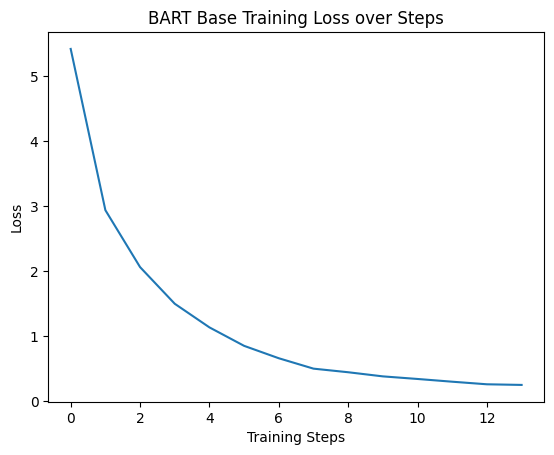

In [33]:
# Plot loss
import matplotlib.pyplot as plt

plt.plot(loss_logger.get_losses())
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('BART Base Training Loss over Steps')
plt.show()

In [34]:
from transformers import pipeline
import evaluate
from tqdm import tqdm

# Load trained model
model = AutoModelForSeq2SeqLM.from_pretrained("./trained_bart_base")
tokenizer = AutoTokenizer.from_pretrained("./trained_bart_base")

qa_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Load metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

# Generate predictions
predictions, references = [], []

print("Generating predictions on validation set...")
for example in tqdm(tokenized_dataset["validation"]):
    input_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)
    reference_text = tokenizer.decode(example["labels"], skip_special_tokens=True)
    
    output = qa_pipeline(input_text, max_length=64, clean_up_tokenization_spaces=True)[0]['generated_text']
    
    predictions.append(output.strip())
    references.append(reference_text.strip())

# Compute metrics
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
rouge_result = rouge.compute(predictions=predictions, references=references)
meteor_result = meteor.compute(predictions=predictions, references=references)

# Print scores
print("\n===== Evaluation Metrics (BART Base) =====")
print(f"BLEU Score     : {bleu_result['bleu']:.4f}")
print(f"  - Precisions : {[f'{p:.4f}' for p in bleu_result['precisions']]}")
print(f"ROUGE-1        : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2        : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L        : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum     : {rouge_result['rougeLsum']:.4f}")
print(f"METEOR         : {meteor_result['meteor']:.4f}")

Device set to use cuda:0
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Generating predictions on validation set...


100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


===== Evaluation Metrics (BART Base) =====
BLEU Score     : 0.2456
  - Precisions : ['0.4396', '0.2681', '0.1994', '0.1607']
ROUGE-1        : 0.4610
ROUGE-2        : 0.2822
ROUGE-L        : 0.3705
ROUGE-Lsum     : 0.3720
METEOR         : 0.3601
